In [1]:
from likelihood import discrete_loglikelihood
from SS_DM_Prior import SS_DM_dist_setup
from prior import discrete_logprior
import numpy as np
from scipy.special import logsumexp
from scipy import interpolate
from matplotlib import pyplot as plt
import pandas as pd

# disc_like = discrete_loglikelihood(logfunction=lambda x, y: x*y, axes=np.linspace(0,1,100), dependent_axes=np.linspace(1,2,100))
# disc_prior = discrete_logprior(logfunction=lambda x, y, z, w: np.log(np.abs(y+x-w)*z), name='test',
#                                axes=(np.linspace(0,1,101), np.linspace(0,1,51),), axes_names=['energy', 'offset'],
#                                default_hyperparameter_values=(1,1), hyperparameter_names=['h1', 'h2'])

/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# disc_prior

In [3]:
# plt.figure()
# plt.hist2d(*disc_prior.sample(100000), bins=(50,50))
# plt.show()

In [4]:
darkSUSY_to_Gammapy_converter = {
    "tt": "t",
    "W+W-": "W",
    "ZZ": "Z",
    "HH": "h",
}

darkSUSY_BFs_cleaned = pd.read_csv('BFCalc/darkSUSY_BFs/darkSUSY_BFs_cleaned.csv', delimiter=' ')

darkSUSY_massvalues = darkSUSY_BFs_cleaned.iloc[:,1]/1e3

darkSUSY_lambdavalues = darkSUSY_BFs_cleaned.iloc[:,2]

channelfuncdictionary = {}

modulefolderpath = 'BFCalc'
log10xvals = np.load(modulefolderpath+f"/griddata/log10xvals_massenergy_diffflux_grid.npy")
massvalues = np.load(modulefolderpath+f"/griddata/massvals_massenergy_diffflux_grid.npy")

for darkSUSYchannel in list(darkSUSY_to_Gammapy_converter.keys()):
    gammapychannel = darkSUSY_to_Gammapy_converter[darkSUSYchannel]
    
    tempspectragrid = np.load(modulefolderpath+f"/griddata/channel={gammapychannel}_massenergy_diffflux_grid.npy")
    
    channelfuncdictionary[darkSUSYchannel] = interpolate.RegularGridInterpolator((np.log10(massvalues/1e3), log10xvals), np.array(tempspectragrid), 
                                                                                 method='linear', bounds_error=False, fill_value=1e-3000)



partial_sigmav_interpolator_dictionary = {channel: interpolate.LinearNDInterpolator((darkSUSY_massvalues, darkSUSY_lambdavalues),darkSUSY_BFs_cleaned.iloc[:,idx+3]) for idx, channel in enumerate(list(darkSUSY_to_Gammapy_converter.keys()))}



def nontrivial_coupling(logmass, logenergy, coupling=0.1, partial_sigmav_interpolator_dictionary=partial_sigmav_interpolator_dictionary, channelfuncdictionary=channelfuncdictionary ):
    
    
    logspectra = -np.inf
    for channel in channelfuncdictionary.keys():
        logspectra = np.logaddexp(logspectra, np.log(partial_sigmav_interpolator_dictionary[channel](10**logmass, coupling)*channelfuncdictionary[channel]((logmass, logenergy-logmass))))
    
    
    return logspectra
        

In [5]:
from utils3d import longitudeaxistrue, latitudeaxistrue, log10eaxistrue


logDMpriorfunc = SS_DM_dist_setup(nontrivial_coupling, longitudeaxistrue, latitudeaxistrue)

In [6]:
DM_prior = discrete_logprior(logfunction=logDMpriorfunc, name='Scalar Singlet Dark Matter Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), axes_names=['energy', 'lon', 'lat'],
                               default_hyperparameter_values=(1,), hyperparameter_names=['mass'])
DM_prior

(1,)


discrete log prior class
----------------------------
name = Scalar Singlet Dark Matter Prior
logfunction type is <function SS_DM_dist_setup.<locals>.DM_signal_dist at 0x7ff27402f9d0>
input units of None
over axes ['energy', 'lon', 'lat']
with hyperparameter(s) ['mass']

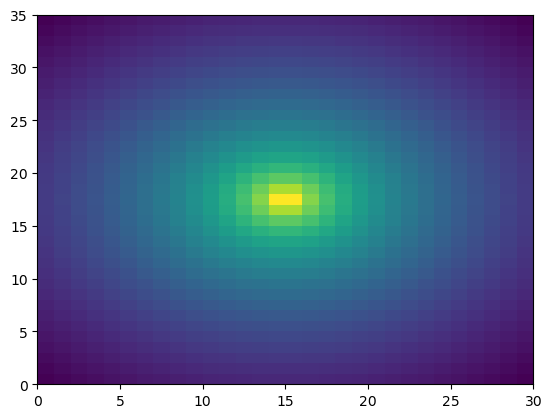

In [7]:
logprior = DM_prior.sample(int(1e3))

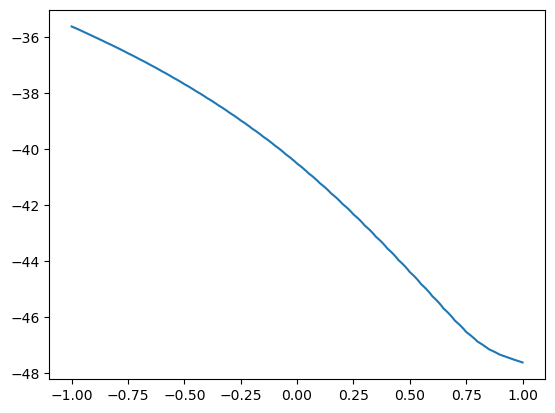

In [8]:
plt.plot(log10eaxistrue, DM_prior((log10eaxistrue, 0.0, 0.0), (1.0,)))
plt.show()

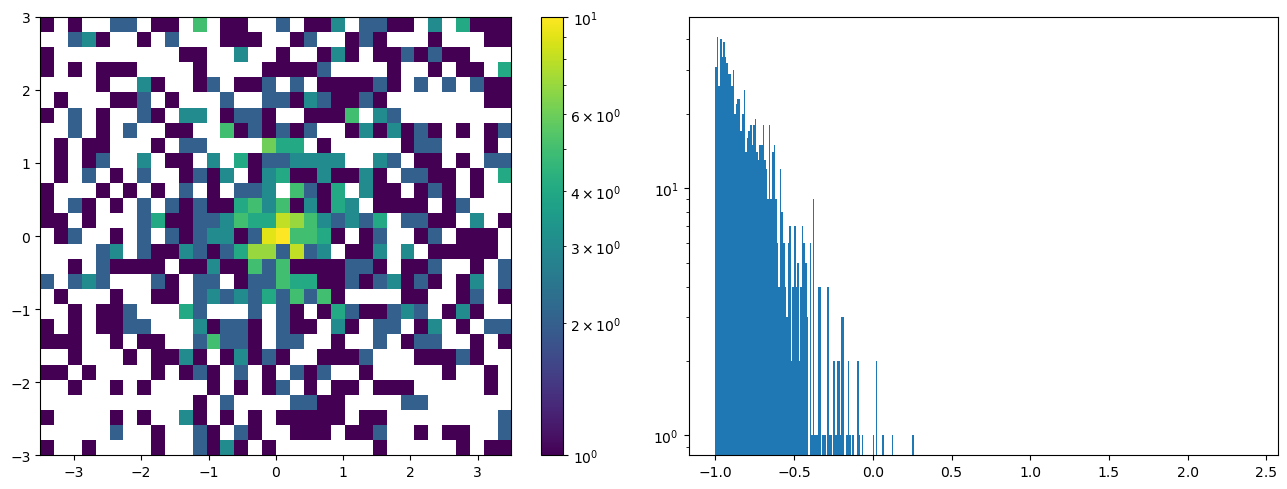

In [9]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.hist2d(logprior[1,:], logprior[2,:], bins=(longitudeaxistrue, latitudeaxistrue), norm=LogNorm())
plt.colorbar()

plt.subplot(1,2,2)
plt.hist(logprior[0,:], bins=log10eaxistrue,)
plt.yscale('log')

plt.tight_layout()

In [10]:
astrophysicalbackground = np.load("unnormalised_astrophysicalbackground.npy")
from utils3d import bkgdist

nuisancemesh = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')

unnormed_logbkgpriorvalues = np.logaddexp(np.squeeze(bkgdist(*nuisancemesh)),np.log(astrophysicalbackground))


logbkgfunc_annoying = interpolate.RegularGridInterpolator((log10eaxistrue, longitudeaxistrue, latitudeaxistrue), np.exp(unnormed_logbkgpriorvalues))
logbkgfunc = lambda logenergy, longitude, latitude: np.log(logbkgfunc_annoying((logenergy, longitude, latitude)))


bkg_prior = discrete_logprior(logfunction=logbkgfunc, name='Background Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), 
                               axes_names=['energy', 'lon', 'lat'],)

In [11]:
bkg_prior((0.0,0.0,0.0))

array(3.30634158)

/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/scipy/interpolate/_rgi.py:358: RuntimeWarning: invalid value encountered in multiply
  values += np.asarray(self.values[edge_indices]) * weight[vslice]


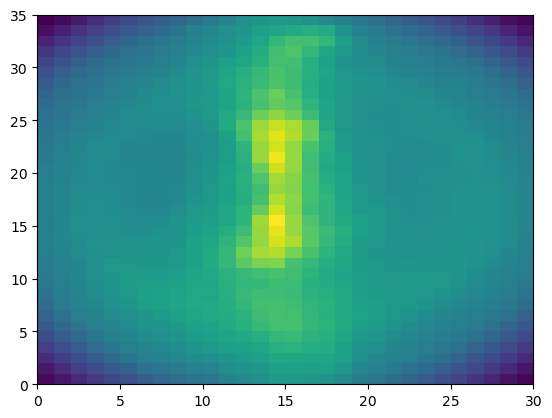

array([[-1. , -1. , -1. , ..., -1. , -1. , -1. ],
       [-3.5, -3.5, -3.5, ..., -3.5, -3.5, -3.5],
       [-3. , -3. , -3. , ..., -3. , -3. , -3. ]])

In [12]:
bkg_samples = bkg_prior.sample(10000)

bkg_samples

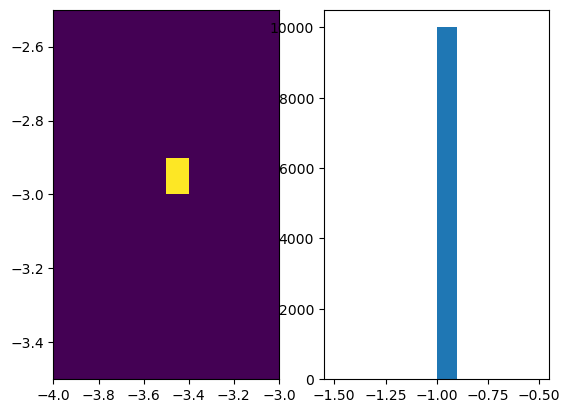

In [13]:
plt.figure()

plt.subplot(1,2,1)
plt.hist2d(bkg_samples[1,:], bkg_samples[2,:])

plt.subplot(1,2,2)
plt.hist(bkg_samples[0,:])
plt.show()

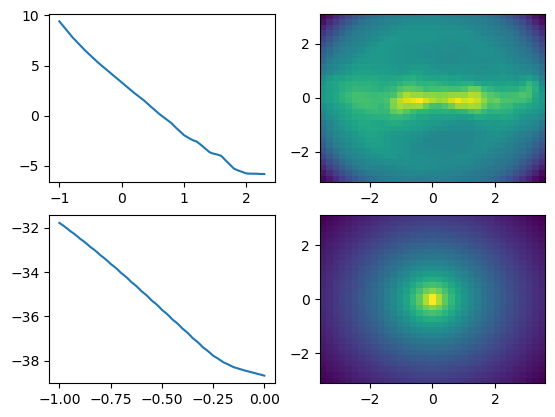

In [14]:

plt.figure()

plt.subplot(221)
plt.plot(log10eaxistrue, bkg_prior((log10eaxistrue,0.0,0.0)))
plt.subplot(222)
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, bkg_prior((*np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij'),))[160,:,:].T)

plt.subplot(223)
plt.plot(log10eaxistrue, logDMpriorfunc(log10eaxistrue,0.0,0.0, 0.0))
plt.subplot(224)
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, logDMpriorfunc(0.0,*np.meshgrid(longitudeaxistrue, latitudeaxistrue), 0.0))
plt.show()